# Leeds property price analytics

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# force full-width display if viewed in Chrome browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Download UK Land Registry price-paid data and create bigquery dataset

In [2]:
#   # download data to the VM from source: https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads
#   !wget http://prod.publicdata.landregistry.gov.uk.s3-website-eu-west-1.amazonaws.com/pp-complete.csv
#   
#   # move to gcp bucket
#   !gsutil mv pp-complete.csv gs://housingasodhfmq349p78vp57pasvpfphio/pp-complete.csv
#       
#       # make bigquery database
#   !bq mk housing
#   
#   # create table called 'pricepaid' in housing database
#   !bq load --source_format=CSV \
#       housing.pricepaid gs://housingasodhfmq349p78vp57pasvpfphio/pp-complete.csv \
#       trans_id:STRING,price:INTEGER,date:STRING,postcode:STRING,type:STRING,newbuild:STRING,tenure:STRING,paon:STRING,saon:STRING,street:STRING,locality:STRING,town_city:STRING,district:STRING,county:STRING,ppd_type:STRING,record_status:STRING

## Query data

In [3]:
%%bigquery df

SELECT * FROM housing.pricepaid
WHERE town_city = 'LEEDS'

Downloading: 100%|██████████| 304179/304179 [00:02<00:00, 147427.66rows/s]


## Inspect dataframe

In [4]:
df.head(4)

,trans_id,price,date,postcode,type,newbuild,tenure,paon,saon,street,locality,town_city,district,county,ppd_type,record_status
0,{EC8D5961-92BD-4620-99AB-1AF4671C3473},152000,1996-10-21 00:00,LS16 9HQ,D,N,F,10,,MANOR CLOSE,BRAMHOPE,LEEDS,LEEDS,WEST YORKSHIRE,A,A
1,{D4CE84D1-D3A3-48BD-AF3F-8A29F7DCBE3B},145000,2012-07-27 00:00,LS14 2HR,D,N,F,22,,FARNHAM CROFT,,LEEDS,LEEDS,WEST YORKSHIRE,A,A
2,{71E81A98-74F7-4992-9DB0-2F40B0D5669E},220000,2008-09-26 00:00,LS15 9JF,D,N,F,2,,HOLLY TREE LANE,LEEDS,LEEDS,LEEDS,WEST YORKSHIRE,A,A
3,{EFF70FE5-C98A-456F-A388-28B2759AFD72},240000,2008-01-25 00:00,LS17 8PT,D,N,F,16,,LINTON AVENUE,LEEDS,LEEDS,LEEDS,WEST YORKSHIRE,A,A


In [5]:
df.nunique()

trans_id         304179
price             12114
date               7728
postcode          14079
type                  5
newbuild              2
tenure                3
paon               6221
saon               2351
street             8965
locality            120
town_city             1
district             11
county                4
ppd_type              2
record_status         1
dtype: int64

In [6]:
# check data types
df.dtypes

trans_id         object
price             int64
date             object
postcode         object
type             object
newbuild         object
tenure           object
paon             object
saon             object
street           object
locality         object
town_city        object
district         object
county           object
ppd_type         object
record_status    object
dtype: object

## Pre-processing

### 1. Postcode

In [7]:
# Some rows have missing postcodes
len(df[df['postcode'] == ''])

201

In [8]:
# Check for null entries in postcode column
len(df[df['postcode'].isnull()])

0

In [9]:
# Discard rows with empty string postcodes 
df = df[df['postcode'] != '']

In [10]:
# Check that all postcodes have space
len(df[df['postcode'].str.contains(' ')]) == len(df)

True

In [11]:
# Break down postcodes into components: area, district, sector ,and unit. 
def get_postcode_components(postcode):
    
    """
    Returns part of all of a postcode string resolved into area, district, sector or unit. 
    
    UK postcodes take any of the following formats, where A denotes alphabetical
    and N denotes numeric:
    
    AN NAA 
    ANN NAA
    AAN NAA
    AANN NAA
    ANA NAA
    AANA NAA
    
    (source: https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/611951/Appendix_C_ILR_2017_to_2018_v1_Published_28April17.pdf)
    
    - Area is the leftmost substring of alpha characters until (and excluding) a numeric character .Format: A or AA.
    - District is the substring commencing with numeric after the area, and before the space. Format: N, NN, or NA.
    - Sector is the first numeric character after the space. Format: N.
    - Unit is the rightmost substring. Format: AA.
   
    e.g.:
    >> get_postcode_component('RG40 2WD', component='sector')
    >> RG40 2   
    
    e.g. 2:
    >> get_postcode_component('EC1A 3HX', component='area')
    >> EC
    
    e.g. 3:
    >> get_postcode_component('EC1A 3HX', component='district')
    >> EC1A
    """
    
    # e.g. EC1A 3HX
    area_and_district = postcode.split(' ')[0] # EC1A
    sector_and_unit = postcode.split(' ')[1] # 3HX
        
    for index, char in enumerate(area_and_district):
        if char.isnumeric():
            area = area_and_district[:index] # EC
            district = area_and_district[index:] #1A
            break

    for index, char in enumerate(sector_and_unit):
        if char.isnumeric():
            unit = sector_and_unit[index+1:] # 3
            sector = sector_and_unit[:index+1] # HX
            break
    
    return dict({'area':area, 'district':area+district, 'sector':area+district+' '+sector, 'unit':area+district+' '+sector+unit})


# tests
test_postcodes = ['A1 2BC', 'A12 3BC', 'AB1 2BC', 'AB12 3CD', 'A1B 2BC', 'AB1C 2DE']
for postcode in test_postcodes:
    print(postcode, get_postcode_components(postcode))

A1 2BC {'area': 'A', 'district': 'A1', 'sector': 'A1 2', 'unit': 'A1 2BC'}
A12 3BC {'area': 'A', 'district': 'A12', 'sector': 'A12 3', 'unit': 'A12 3BC'}
AB1 2BC {'area': 'AB', 'district': 'AB1', 'sector': 'AB1 2', 'unit': 'AB1 2BC'}
AB12 3CD {'area': 'AB', 'district': 'AB12', 'sector': 'AB12 3', 'unit': 'AB12 3CD'}
A1B 2BC {'area': 'A', 'district': 'A1B', 'sector': 'A1B 2', 'unit': 'A1B 2BC'}
AB1C 2DE {'area': 'AB', 'district': 'AB1C', 'sector': 'AB1C 2', 'unit': 'AB1C 2DE'}


In [12]:
# create new columns with postcode components
df['pc_area'] = df['postcode'].apply(lambda x: get_postcode_components(x)['area'])
df['pc_district'] = df['postcode'].apply(lambda x: get_postcode_components(x)['district'])
df['pc_sector'] = df['postcode'].apply(lambda x: get_postcode_components(x)['sector'])
df['pc_unit'] = df['postcode'].apply(lambda x: get_postcode_components(x)['unit'])

# drop reduntant post code column
df = df.drop('postcode', axis=1)

### 2. Date

In [13]:
# convert dates to timestamp and discard meaningless hours/minutes data
df['date'] = df['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M'))

# sort by date
df = df.sort_values(by='date')

In [14]:
df.head(10)

,trans_id,price,date,type,newbuild,tenure,paon,saon,street,locality,town_city,district,county,ppd_type,record_status,pc_area,pc_district,pc_sector,pc_unit
93280,{9814661F-EF38-4E76-BC8B-CE526C9DA243},95950,1995-01-02,D,Y,F,8,,BALMORAL WAY,YEADON,LEEDS,LEEDS,WEST YORKSHIRE,A,A,LS,LS19,LS19 7,LS19 7WF
57245,{C8E8856F-E0AB-4B2E-931D-D7BC96E578D3},30000,1995-01-03,T,N,F,7,,THROSTLE HILL,LEEDS,LEEDS,LEEDS,WEST YORKSHIRE,A,A,LS,LS10,LS10 4,LS10 4JH
71895,{7C77563A-B6F8-4E25-8E1D-9816793FBF9C},89500,1995-01-03,S,N,F,43,,RICHMOND MOUNT,HEADINGLEY,LEEDS,LEEDS,WEST YORKSHIRE,A,A,LS,LS6,LS6 1,LS6 1DF
182535,{D1418EA2-7D82-482D-A44C-4143D75A4790},86000,1995-01-03,D,N,F,2,,SANDHILL DRIVE,LEEDS,LEEDS,LEEDS,WEST YORKSHIRE,A,A,LS,LS17,LS17 8,LS17 8DX
255952,{203AC08D-673F-49E7-BBF1-9564E04D9089},59950,1995-01-03,S,Y,F,25,,MERLIN CLOSE,MORLEY,LEEDS,LEEDS,WEST YORKSHIRE,A,A,LS,LS27,LS27 8,LS27 8TS
183806,{2359AE71-7172-45C2-B628-12FBDFEF3F1C},83950,1995-01-03,D,Y,F,45,,PINDERS GREEN DRIVE,METHLEY,LEEDS,LEEDS,WEST YORKSHIRE,A,A,LS,LS26,LS26 9,LS26 9BA
11810,{8431EE39-650B-41F8-A0EC-A30B600809BD},32000,1995-01-03,S,N,F,59,,BROOKLANDS LANE,LEEDS,LEEDS,LEEDS,WEST YORKSHIRE,A,A,LS,LS14,LS14 6,LS14 6QH
64795,{A193850F-25F2-46F3-A379-A3F5C8A34282},140000,1995-01-03,D,N,F,270,,WETHERBY ROAD,LEEDS,LEEDS,LEEDS,WEST YORKSHIRE,A,A,LS,LS17,LS17 8,LS17 8NE
223151,{5DBCD3D4-07F0-4412-9379-DA6E6450B7B1},59950,1995-01-03,S,Y,F,74,,FIELD END ROAD,LEEDS,LEEDS,LEEDS,WEST YORKSHIRE,A,A,LS,LS15,LS15 0,LS15 0PZ
183750,{F817C2E1-91D3-45D5-9F7D-23074F775565},332500,1995-01-03,D,N,F,626,,HARROGATE ROAD,LEEDS,LEEDS,LEEDS,WEST YORKSHIRE,A,A,LS,LS17,LS17 8,LS17 8EP


### 3. Various

In [15]:
# rename column to avoid keyword clash
df.rename(columns={'type': 'property_type'}, inplace=True)

# lower case for aesthetics
df['street'] = df['street'].str.lower()
df['locality'] = df['locality'].str.lower()
df['town_city'] = df['town_city'].str.lower()
df['county'] = df['county'].str.lower()
df['district'] = df['district'].str.lower()

## Data inspection

In [49]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# function to filter by whatever 
def filter_by(dataframe, **kwargs):
    
    """
    Filter a dataframe using arbitrary set of filters on column values 
    """
    
    for key, value in kwargs.items():        
        if key == 'min_price':
            dataframe = dataframe[dataframe['price'] >= value]
        elif key == 'max_price':
            dataframe = dataframe[dataframe['price'] <= value]                
        elif key == 'min_date':
            dataframe = dataframe[dataframe['date'] >= value]
        elif key == 'max_date':
            dataframe = dataframe[dataframe['date'] <= value]
        else:
            dataframe = dataframe[dataframe[key] == value]
        
    return dataframe


df_ = filter_by(dataframe=df,
                property_type='S',
                pc_sector='LS13 2',
                #street='eightlands lane',
                min_price=0,
                max_price=500000,
                min_date='2018-01-01', 
               )


In [56]:
df_.head(10)

,trans_id,price,date,property_type,newbuild,tenure,paon,saon,street,locality,town_city,district,county,ppd_type,record_status,pc_area,pc_district,pc_sector,pc_unit,MA
292998,{64342BFF-2C7C-422C-E053-6C04A8C0FB8A},160000,2018-01-09,S,N,F,57,,south end avenue,,leeds,leeds,west yorkshire,A,A,LS,LS13,LS13 2,LS13 2AD,NaN
227484,{64342BFF-2D34-422C-E053-6C04A8C0FB8A},76000,2018-01-10,S,N,F,16,,ganners road,,leeds,leeds,west yorkshire,B,A,LS,LS13,LS13 2,LS13 2PB,NaN
197012,{64342BFF-3710-422C-E053-6C04A8C0FB8A},136000,2018-01-12,S,N,F,32,,houghley close,,leeds,leeds,west yorkshire,A,A,LS,LS13,LS13 2,LS13 2DS,NaN
255167,{6B32222C-DEC6-01F1-E053-6C04A8C0D2C8},160000,2018-01-19,S,N,F,7,,fall park court,,leeds,leeds,west yorkshire,A,A,LS,LS13,LS13 2,LS13 2LP,NaN
14156,{666758D7-8681-3363-E053-6B04A8C0D74E},67500,2018-02-01,S,N,F,10,,hill court avenue,,leeds,leeds,west yorkshire,A,A,LS,LS13,LS13 2,LS13 2AR,NaN
165547,{68FEB20C-3779-38DA-E053-6C04A8C051AE},225000,2018-02-09,S,N,F,14,,whitecote hill,,leeds,leeds,west yorkshire,A,A,LS,LS13,LS13 2,LS13 2HU,NaN
45973,{68FEB20C-3E8D-38DA-E053-6C04A8C051AE},125000,2018-02-16,S,N,F,21,,hill court drive,,leeds,leeds,west yorkshire,A,A,LS,LS13,LS13 2,LS13 2AN,NaN
136985,{68FEB20C-374F-38DA-E053-6C04A8C051AE},160000,2018-02-16,S,N,F,80,,waterloo lane,,leeds,leeds,west yorkshire,A,A,LS,LS13,LS13 2,LS13 2JF,NaN
79909,{68FEB20C-3B3A-38DA-E053-6C04A8C051AE},116500,2018-02-23,S,N,F,15,,ganners mount,,leeds,leeds,west yorkshire,A,A,LS,LS13,LS13 2,LS13 2PE,NaN
134379,{68FEB20C-3429-38DA-E053-6C04A8C051AE},151000,2018-02-23,S,N,F,10,,waterloo crescent,,leeds,leeds,west yorkshire,A,A,LS,LS13,LS13 2,LS13 2JQ,NaN


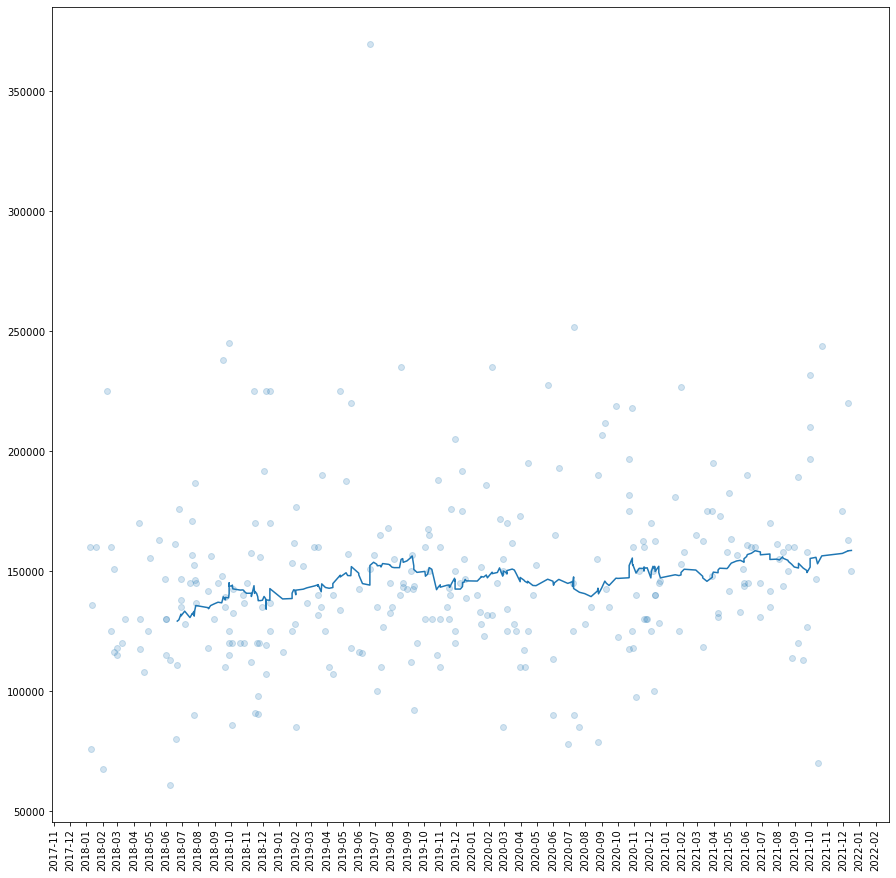

In [55]:
from matplotlib.dates import MonthLocator

def graph2(dataframe):
    
    fig, ax = plt.subplots(1, 1)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    
    # moving price average
    dataframe['MA'] = dataframe['price'].rolling(window=30).mean()
    
    ax.scatter(dataframe['date'], dataframe['price'], alpha=0.2)
    ax.xaxis.set_major_locator(MonthLocator())  #bymonth=1
    ax.tick_params(axis='x', labelrotation=90)
    ax.plot(dataframe['date'], dataframe['MA'])
    

graph2(df_)


## Price changes as a function of price

In [21]:
# old plotting function

def graph(postcode, housetype, streetname, ):

    postcode_type = df[  (df['postcode_area'] == f'{postcode}') & (df['type'] == f'{housetype}') ]
    
    # df for individual street
    street = postcode_type[postcode_type['street'] == f'{streetname}']
    
    # price data for street
    street_price = street.groupby(by=['months_ago']).agg({'price': 'median'})
    
    # moving average for street
    street_price['MA'] = street_price['price'].rolling(window=12).mean()
    
    # price data for postcode area
    postcode_type_price = postcode_type.groupby(by=['months_ago']).agg({'price': 'median'})
    postcode_type_price = postcode_type_price.groupby(by=['months_ago']).agg({'price': 'median'})
    
    # moving average for postcode area
    postcode_type_price['MA'] = postcode_type_price['price'].rolling(window=12).mean()
    
    plt.plot(street_price.index, street_price['price'].values,c='red',  label=f'{streetname}')
    plt.plot(street_price.index, street_price['MA'].values, c='pink',  label=f'{streetname} moving average')
    
    plt.plot(postcode_type_price.index, postcode_type_price['MA'].values ,c='green',  label=f'{postcode, housetype} moving average')
    plt.scatter(postcode_type_price.index, postcode_type_price['price'].values, c='blue', label=f'{postcode, housetype}')
    
    plt.rcParams["figure.figsize"]=(20,20)
    plt.xticks(rotation=90)
    plt.legend(loc='best')
    plt.show()


In [22]:
# choose leeds
leeds = filter_by(df, pc_area='LS')

In [23]:
# filter by timescales spanning the beginning of Covid to present
leeds = leeds[(leeds['date'] > '2019-10-01')]

In [24]:
leeds

,trans_id,price,date,property_type,newbuild,tenure,paon,saon,street,locality,town_city,district,county,ppd_type,record_status,pc_area,pc_district,pc_sector,pc_unit
9539,{A96E4ACC-F55D-9205-E053-6C04A8C0DA09},366500,2019-10-02,O,N,F,SERVICE STATION,,york road,,leeds,leeds,west yorkshire,B,A,LS,LS14,LS14 2,LS14 2AA
69932,{965B6D92-6410-95E4-E053-6C04A8C07729},75000,2019-10-02,O,N,F,73,,domestic street,holbeck,leeds,leeds,west yorkshire,B,A,LS,LS11,LS11 9,LS11 9NS
268996,{A2479555-C222-74C7-E053-6B04A8C0887D},385000,2019-10-02,T,Y,L,77,,solar avenue,,leeds,leeds,west yorkshire,A,A,LS,LS9,LS9 8,LS9 8FU
284527,{98C75472-941F-72E9-E053-6B04A8C042F0},145000,2019-10-02,S,N,F,12,,sunnyview terrace,,leeds,leeds,west yorkshire,A,A,LS,LS11,LS11 8,LS11 8QX
53789,{965B6D92-26FC-95E4-E053-6C04A8C07729},242000,2019-10-02,T,N,F,7,,crofton terrace,,leeds,leeds,west yorkshire,A,A,LS,LS17,LS17 8,LS17 8LD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302470,{D93B27B1-A989-3100-E053-6C04A8C08887},261000,2022-02-18,T,N,F,11,,methley terrace,,leeds,leeds,west yorkshire,A,A,LS,LS7,LS7 3,LS7 3NL
207868,{D93B27B1-F3E4-3100-E053-6C04A8C08887},116000,2022-02-18,T,N,F,49,,longroyd grove,,leeds,leeds,west yorkshire,B,A,LS,LS11,LS11 5,LS11 5HF
168119,{D93B27B1-B187-3100-E053-6C04A8C08887},232000,2022-02-18,S,N,F,26,,new village way,churwell,leeds,leeds,west yorkshire,A,A,LS,LS27,LS27 7,LS27 7GD
199115,{D93B27B1-F4E1-3100-E053-6C04A8C08887},205000,2022-02-18,S,N,F,93,,moorgate road,kippax,leeds,leeds,west yorkshire,B,A,LS,LS25,LS25 7,LS25 7ET


In [25]:
t = leeds['date'].max() -  leeds['date'].min()

In [26]:
from dateutil import relativedelta

def get_months_difference(timestamp1, timestamp2):
    
    r = relativedelta.relativedelta(timestamp1, timestamp2)

    months_diff = (r.years * 12) + r.months
    
    return months_diff

In [27]:
leeds['months_ago'] = leeds['date'].apply(lambda x: get_months_difference(datetime.today(), x))

In [28]:
datetime.today() - leeds['date'].max()

Timedelta('56 days 13:02:20.437939')

In [29]:
leeds

,trans_id,price,date,property_type,newbuild,tenure,paon,saon,street,locality,town_city,district,county,ppd_type,record_status,pc_area,pc_district,pc_sector,pc_unit,months_ago
9539,{A96E4ACC-F55D-9205-E053-6C04A8C0DA09},366500,2019-10-02,O,N,F,SERVICE STATION,,york road,,leeds,leeds,west yorkshire,B,A,LS,LS14,LS14 2,LS14 2AA,30
69932,{965B6D92-6410-95E4-E053-6C04A8C07729},75000,2019-10-02,O,N,F,73,,domestic street,holbeck,leeds,leeds,west yorkshire,B,A,LS,LS11,LS11 9,LS11 9NS,30
268996,{A2479555-C222-74C7-E053-6B04A8C0887D},385000,2019-10-02,T,Y,L,77,,solar avenue,,leeds,leeds,west yorkshire,A,A,LS,LS9,LS9 8,LS9 8FU,30
284527,{98C75472-941F-72E9-E053-6B04A8C042F0},145000,2019-10-02,S,N,F,12,,sunnyview terrace,,leeds,leeds,west yorkshire,A,A,LS,LS11,LS11 8,LS11 8QX,30
53789,{965B6D92-26FC-95E4-E053-6C04A8C07729},242000,2019-10-02,T,N,F,7,,crofton terrace,,leeds,leeds,west yorkshire,A,A,LS,LS17,LS17 8,LS17 8LD,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302470,{D93B27B1-A989-3100-E053-6C04A8C08887},261000,2022-02-18,T,N,F,11,,methley terrace,,leeds,leeds,west yorkshire,A,A,LS,LS7,LS7 3,LS7 3NL,1
207868,{D93B27B1-F3E4-3100-E053-6C04A8C08887},116000,2022-02-18,T,N,F,49,,longroyd grove,,leeds,leeds,west yorkshire,B,A,LS,LS11,LS11 5,LS11 5HF,1
168119,{D93B27B1-B187-3100-E053-6C04A8C08887},232000,2022-02-18,S,N,F,26,,new village way,churwell,leeds,leeds,west yorkshire,A,A,LS,LS27,LS27 7,LS27 7GD,1
199115,{D93B27B1-F4E1-3100-E053-6C04A8C08887},205000,2022-02-18,S,N,F,93,,moorgate road,kippax,leeds,leeds,west yorkshire,B,A,LS,LS25,LS25 7,LS25 7ET,1


In [30]:
leeds[leeds['months_ago'] == 2]['price'].mean()

220985.9

In [31]:
leeds[leeds['months_ago'] == 28]['price'].mean()

259302.53211888782

In [32]:
leeds['mean_price'] = leeds['months_ago'].apply(lambda x: leeds[leeds['months_ago'] == x]['price'].mean())

In [33]:
leeds

,trans_id,price,date,property_type,newbuild,tenure,paon,saon,street,locality,town_city,district,county,ppd_type,record_status,pc_area,pc_district,pc_sector,pc_unit,months_ago,mean_price
9539,{A96E4ACC-F55D-9205-E053-6C04A8C0DA09},366500,2019-10-02,O,N,F,SERVICE STATION,,york road,,leeds,leeds,west yorkshire,B,A,LS,LS14,LS14 2,LS14 2AA,30,239660.482301
69932,{965B6D92-6410-95E4-E053-6C04A8C07729},75000,2019-10-02,O,N,F,73,,domestic street,holbeck,leeds,leeds,west yorkshire,B,A,LS,LS11,LS11 9,LS11 9NS,30,239660.482301
268996,{A2479555-C222-74C7-E053-6B04A8C0887D},385000,2019-10-02,T,Y,L,77,,solar avenue,,leeds,leeds,west yorkshire,A,A,LS,LS9,LS9 8,LS9 8FU,30,239660.482301
284527,{98C75472-941F-72E9-E053-6B04A8C042F0},145000,2019-10-02,S,N,F,12,,sunnyview terrace,,leeds,leeds,west yorkshire,A,A,LS,LS11,LS11 8,LS11 8QX,30,239660.482301
53789,{965B6D92-26FC-95E4-E053-6C04A8C07729},242000,2019-10-02,T,N,F,7,,crofton terrace,,leeds,leeds,west yorkshire,A,A,LS,LS17,LS17 8,LS17 8LD,30,239660.482301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302470,{D93B27B1-A989-3100-E053-6C04A8C08887},261000,2022-02-18,T,N,F,11,,methley terrace,,leeds,leeds,west yorkshire,A,A,LS,LS7,LS7 3,LS7 3NL,1,263460.000000
207868,{D93B27B1-F3E4-3100-E053-6C04A8C08887},116000,2022-02-18,T,N,F,49,,longroyd grove,,leeds,leeds,west yorkshire,B,A,LS,LS11,LS11 5,LS11 5HF,1,263460.000000
168119,{D93B27B1-B187-3100-E053-6C04A8C08887},232000,2022-02-18,S,N,F,26,,new village way,churwell,leeds,leeds,west yorkshire,A,A,LS,LS27,LS27 7,LS27 7GD,1,263460.000000
199115,{D93B27B1-F4E1-3100-E053-6C04A8C08887},205000,2022-02-18,S,N,F,93,,moorgate road,kippax,leeds,leeds,west yorkshire,B,A,LS,LS25,LS25 7,LS25 7ET,1,263460.000000


In [ ]:
leeds['price_diff'] = leeds['price'] - leeds['mean_price']

In [ ]:
leeds['price_ratio'] = leeds['price'] / leeds['mean_price']

In [ ]:
test = leeds[leeds['months_ago'] == 28]

plt.scatter(test['price'], test['price_diff'])
     
plt.rcParams["figure.figsize"]=(20,20)
plt.xticks(rotation=90)
#plt.xlim(0, 500000)
#plt.ylim(-1, 100000)

plt.show()

In [ ]:
#df.plot(x='date', y='price')
#plt.show()

In [ ]:
# df = df.sort_values('date')
# 
# df['street'] = df['street'].astype(str)
# df['street'] = df['street'].apply(lambda x: x.lower())
# 
# df['days_ago'] = df['date'].apply(lambda x: datetime.today() - datetime.strptime(x, '%Y-%m-%d'))
# df['days_ago'] = df['days_ago'].apply(lambda x: str(x).split(' ')[0])
# df['days_ago'] = df['days_ago'].apply(lambda x: -int(x))
# df['months_ago'] = df['days_ago'].apply(lambda x: int(round( x/(365/12) ,0) ))

In [ ]:
# def graph(postcode, housetype, streetname):
# 
#     import matplotlib.pyplot as plt
# 
#     postcode_type = df[  (df['postcode_area'] == f'{postcode}') & (df['type'] == f'{housetype}') ]
#     
#     # df for individual street
#     street = postcode_type[postcode_type['street'] == f'{streetname}']
#     
#     # price data for street
#     street_price = street.groupby(by=['months_ago']).agg({'price': 'median'})
#     
#     # moving average for street
#     street_price['MA'] = street_price['price'].rolling(window=12).mean()
#     
#     # price data for postcode area
#     postcode_type_price = postcode_type.groupby(by=['months_ago']).agg({'price': 'median'})
#     postcode_type_price = postcode_type_price.groupby(by=['months_ago']).agg({'price': 'median'})
#     
#     # moving average for postcode area
#     postcode_type_price['MA'] = postcode_type_price['price'].rolling(window=12).mean()
#     
#     plt.plot(street_price.index, street_price['price'].values,c='red',  label=f'{streetname}')
#     plt.plot(street_price.index, street_price['MA'].values, c='pink',  label=f'{streetname} moving average')
#     
#     plt.plot(postcode_type_price.index, postcode_type_price['MA'].values ,c='green',  label=f'{postcode, housetype} moving average')
#     plt.scatter(postcode_type_price.index, postcode_type_price['price'].values, c='blue', label=f'{postcode, housetype}')
#     
#     plt.rcParams["figure.figsize"]=(20,20)
#     plt.xticks(rotation=90)
#     plt.legend(loc='best')
#     plt.show()

In [ ]:
def mortgage(principal, total_period, init_period, init_payment, init_rate, subs_rate, base_rate, over_payment):
    
    """
    Mortgage payment calculator. Returns dictionary of arrays
    
    principal: amount borrowed in arbitrary currency, e.g. 500000
    total_period: total mortgage duration in months
    init_period: initial term duration in months
    init_payment: initial monthly payment amount, e.g. 1205
    init_rate: initial interest rate expressed as a decimal. e.g. 0.0146 for 1.46%
    subs_rate: subsequent interest rate expressed as a decimal. e.g. 0.0376 for 3.76%
    base_rate: Bank of England base rate. e.g. 0.001 for 0.1%
    over_payment: optional fixed monthly overpayment
    """    
    
    # create arrays for plotting
    interest_values = []
    payment_values = []
    over_payment_values = []
    principal_values = []
    interest_cum_values = []
   
    # calculate initial max overpayment
    max_monthly_overpayment = principal*0.1*(1/12)
    
    # cumulative interest
    interest_cum = 0
    
    # payments for months of initial period
    for month in range(0, init_period):
        
        # update max available monthly overpayment each year
        if month % 12 == 0:
            max_monthly_overpayment = principal*0.1*(1/12)
            
        # calculate interest
        interest = principal*(1 + init_rate)**(1/12) - principal
        
        # add to interest for this month to total interest charged
        interest_cum += interest
    
        # add interest for current month
        principal += interest
     
        # subtract payment amount from principal
        if principal < init_payment:
            principal -= principal
            #stop payments if principal paid off
            init_payment=0 
            subs_payment=0
            over_payment=0
        else:
            principal -= init_payment       
            
        # subtract overpayment from principal
        if over_payment > max_monthly_overpayment:
            over_payment = max_monthly_overpayment

            if principal < over_payment:
                principal -= principal
                init_payment=0 
                subs_payment=0
                over_payment=0
            else:
                principal -= over_payment
        else:
            if principal < over_payment:
                principal -= principal
                init_payment=0 
                subs_payment=0
                over_payment=0
            else:
                principal -= over_payment
   
        # populate arrays for plotting
        interest_values.append(interest)
        interest_cum_values.append(interest_cum)
        payment_values.append(init_payment)
        over_payment_values.append(over_payment)
        principal_values.append(principal)
   
    # calculate payments for remaining balance at new rate
    subs_payment = ((((subs_rate+base_rate)/12))*((1+((subs_rate+base_rate)/12))**(total_period-init_period)) / (((1+((subs_rate+base_rate)/12))**(total_period-init_period)) - 1))*(principal)
    
    # payments for subsequent months
    for month in range(init_period, total_period):
        
        # interest added
        interest = principal*(1 + (subs_rate+base_rate))**(1/12) - principal
        
        # add to cumulative interest 
        interest_cum += interest
            
        # add interest for current month
        principal += interest
    
        # subtract (minimum) payment amount from principal
        if principal < subs_payment:
            principal -= principal
            #stop payments if principal paid off
            init_payment=0 
            subs_payment=0
            over_payment=0
        else:
            principal -= subs_payment
            
        # subtract overpayment amount from principal
        if principal < over_payment:
            principal -= principal
            #stop payments if principal paid off
            init_payment=0 
            subs_payment=0
            over_payment=0

        else:
            principal -= over_payment
        
        # populate arrays for plotting
        interest_values.append(interest)
        interest_cum_values.append(interest_cum)
        payment_values.append(subs_payment)
        over_payment_values.append(over_payment)
        principal_values.append(principal)
        
    results = dict.fromkeys(['Interest', 'Payments', 'Overpayments', 'Principal'])
    results['Interest'] = interest_values
    results['Payments'] = payment_values
    results['Overpayments'] = over_payment_values
    results['Principal'] = principal_values
    
    return results